In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

C:\Users\walids\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../Data/MNIST_data/",one_hot=True)

W0527 10:05:51.473789  4504 deprecation.py:323] From <ipython-input-2-a1af77ee5862>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0527 10:05:51.474202  4504 deprecation.py:323] From C:\Users\walids\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0527 10:05:51.476255  4504 deprecation.py:323] From C:\Users\walids\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../Data/MNIST_data/train-images-idx3-ubyte.gz


W0527 10:05:57.345745  4504 deprecation.py:323] From C:\Users\walids\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0527 10:05:57.354966  4504 deprecation.py:323] From C:\Users\walids\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../Data/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../Data/MNIST_data/t10k-images-idx3-ubyte.gz


W0527 10:05:58.781491  4504 deprecation.py:323] From C:\Users\walids\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../Data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def generator(z,y, reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=tf.concat([z, y], 1),units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=tf.concat([hidden1, y], 1),units=128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(tf.concat([hidden2, y], 1),units=784,activation=tf.nn.tanh)
        return output

In [4]:
def discriminator(X, y ,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=tf.concat([X, y], 1),units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=tf.concat([hidden1, y], 1),units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(tf.concat([hidden2, y], 1),units=1)
        output = tf.sigmoid(logits)
    
        return output, logits

In [5]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [6]:
# placeholders
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])
y = tf.placeholder(tf.float32,shape=[None,10])

In [7]:
G = generator(z , y)

W0527 10:07:33.565224  4504 deprecation.py:323] From <ipython-input-3-d377162d048e>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0527 10:07:33.570212  4504 deprecation.py:506] From C:\Users\walids\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
D_output_real , D_logits_real = discriminator(real_images,y)

In [9]:
D_output_fake, D_logits_fake = discriminator(G,y, reuse=True)

In [10]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [11]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))

In [12]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [13]:
D_loss = D_real_loss + D_fake_loss

In [14]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

In [15]:
learning_rate = 0.001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [17]:
print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [18]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

W0527 10:10:46.692935  4504 deprecation.py:506] From C:\Users\walids\Anaconda3\lib\site-packages\tensorflow\python\training\slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
batch_size = 100
epochs = 500
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)
nAgents = 1

In [24]:
num_samples = 10
episode_interval = 10
samples = np.empty((epochs//episode_interval + 1, num_samples,784))
count = 0
D_loss_total = np.empty(epochs)
G_loss_total = np.empty(epochs)

imageDataSet = mnist.train.images
labels = mnist.train.labels
#imageDataSet = imageDataSet[np.where(mnist.train.labels == 6 )]
#np.random.shuffle(imageDataSet)
IMAGES = np.array_split(imageDataSet,nAgents)
LABELS = np.array_split(labels,nAgents)
imageDataSet = IMAGES[0]
labels = LABELS[0]
IDENTITY = np.identity(10)

In [25]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = len(imageDataSet) // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch, batch_labels = next_batch(batch_size,imageDataSet, labels)
            
            # Get images, reshape and rescale to pass to D
            
            batch_images = batch*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z , y: batch_labels})
            _ = sess.run(G_trainer, feed_dict={z: batch_z, y: batch_labels})
            D_loss_total[e] = sess.run(D_loss, feed_dict={real_images: batch_images, z: batch_z, y: batch_labels})
            G_loss_total[e] = sess.run(G_loss, feed_dict={z: batch_z, y: batch_labels})
        
        if e % episode_interval == 0:
            print("Currently on Epoch {} of {} total...".format(e+1, epochs))
            
            # Sample from generator as we're training for viewing afterwards
            sample_z = np.random.uniform(-1, 1, size=(num_samples, 100))
            gen_sample = sess.run(generator(z , y,reuse=True),feed_dict={z: sample_z, y: IDENTITY})
            samples[count] = gen_sample
            count += 1
            scipy.io.savemat('./results/stdGAN_cond_b100_N1.mat', dict(samples=samples,D_loss_total = D_loss_total,G_loss_total = G_loss_total, epoch = e))
            saver.save(sess, './models/stdGAN_cond_b100_N1.ckpt')

#        samples.append(gen_sample)
        
    saver.save(sess, './models/stdGAN_cond_b100_N1.ckpt')


scipy.io.savemat('./results/stdGAN_cond_b100_N1.mat', dict(samples=samples,D_loss_total = D_loss_total,G_loss_total = G_loss_total, epoch = epochs))

Currently on Epoch 1 of 500 total...
Currently on Epoch 11 of 500 total...
Currently on Epoch 21 of 500 total...
Currently on Epoch 31 of 500 total...
Currently on Epoch 41 of 500 total...
Currently on Epoch 51 of 500 total...
Currently on Epoch 61 of 500 total...
Currently on Epoch 71 of 500 total...
Currently on Epoch 81 of 500 total...
Currently on Epoch 91 of 500 total...
Currently on Epoch 101 of 500 total...
Currently on Epoch 111 of 500 total...
Currently on Epoch 121 of 500 total...
Currently on Epoch 131 of 500 total...
Currently on Epoch 141 of 500 total...
Currently on Epoch 151 of 500 total...
Currently on Epoch 161 of 500 total...
Currently on Epoch 171 of 500 total...
Currently on Epoch 181 of 500 total...
Currently on Epoch 191 of 500 total...
Currently on Epoch 201 of 500 total...
Currently on Epoch 211 of 500 total...
Currently on Epoch 221 of 500 total...
Currently on Epoch 231 of 500 total...
Currently on Epoch 241 of 500 total...
Currently on Epoch 251 of 500 total.

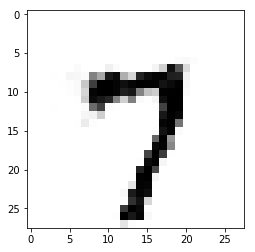

In [27]:
plt.imshow(samples[10][7].reshape(28,28),cmap='Greys')

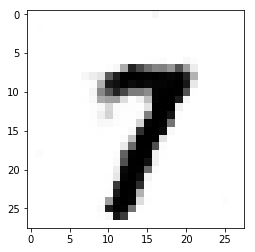

In [28]:
plt.imshow(samples[48][7].reshape(28,28),cmap='Greys')

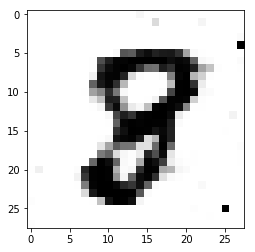

In [30]:
plt.imshow(samples[40][8].reshape(28,28),cmap='Greys')

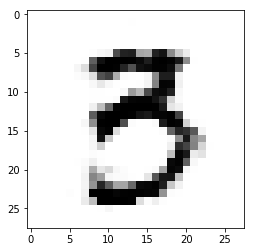

In [32]:
plt.imshow(samples[40][3].reshape(28,28),cmap='Greys')